# 주연 배우의 연령대와 시청률의 상관관계

---

## 개요

이전 스토리에서 21년 드라마의 경우에는<br>
출연 배우의 연령대가 20대이면 낮은 시청률을 보인다는 결론을 내렸다.<p>
    
이번에는 16년도 이후로 드라마의 수도 늘리고,<br>
큰 비중을 차지하지 않는 조연들은 제외하고 주연들의 연령대로만 상관관계를 보고자 한다.

---

In [1]:
#시각화
from IPython.display import Image
import plotly.express as px
#기타
import pandas as pd
import numpy as np
#MongoDB
from dotenv import load_dotenv
import pymongo
import os

In [2]:
# login mongodb
load_dotenv()
mongoadress = os.environ['MONGODB_KEY']
client = pymongo.MongoClient(mongoadress)
db = client.drama

## 데이터

### 배우들의 나이

배우들의 출생년도를 통해서 현재 나이를 구했다. ( ~~한국 나이~~ ) <p>
    
csv파일로 불러온 데이터를 간략히 보자.

In [3]:
age_df = pd.read_csv('data/gt_2016_actorage.csv',encoding='utf-8')

In [4]:
age_df_check = age_df.copy()

# get age
for i, born in enumerate(age_df_check['born']):
    if born is not np.nan:
        age_df_check.loc[i, 'born'] = 2021 - int(age_df_check.iloc[i]['born'][:4])
        
age_df_check = age_df_check.rename(columns={'배우 url':'배우url'})

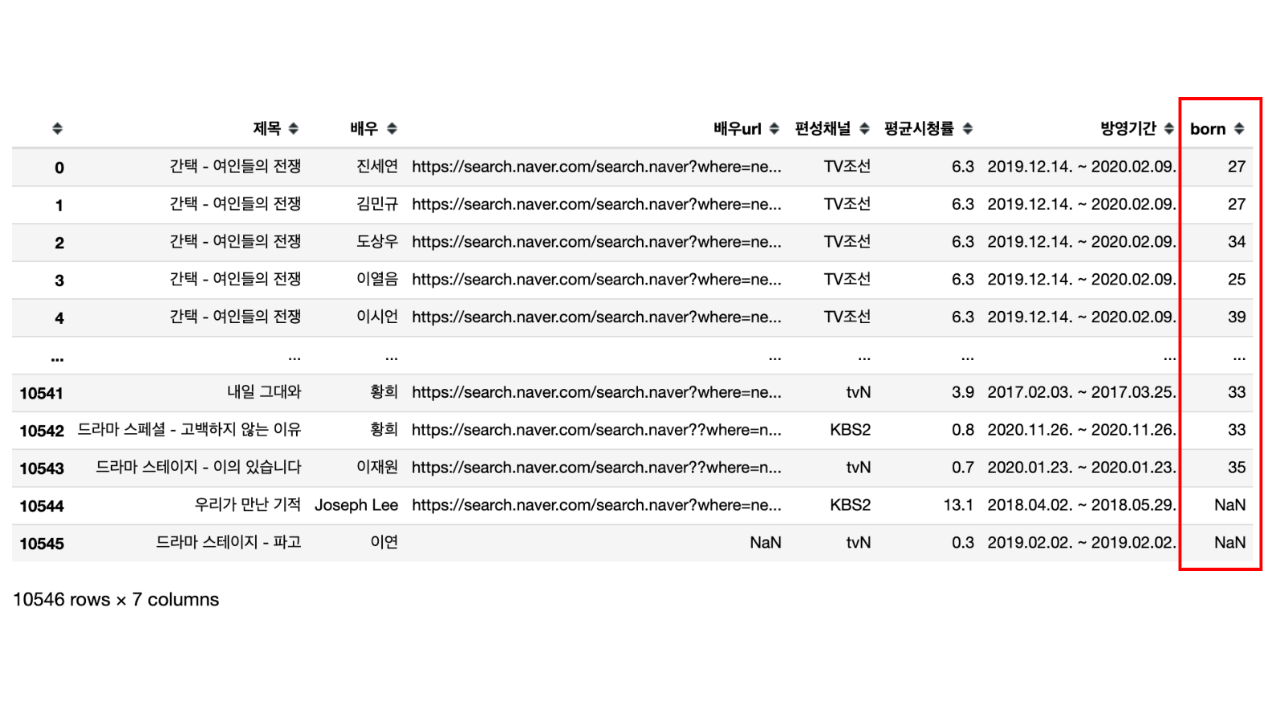

In [5]:
Image('img/age_df.png',width=900,height=900)

### 배우들의 주·조연 정보

In [6]:
# db find query
select_query = {'_id':0,'제목':1,'등장인물.배우':1,'등장인물.배우 url':1,'등장인물.주조연':1}
find_query = {'방영정보.방영기간':{'$gt':'2016'}}

# db cusor
require_cusor = db.require_update_phome_data.find({},select_query)
end_cusor = db.end_drama_phome_data.find(find_query,select_query)

# make list to make dateframe
title_list = []
actor_name_list = []
url_list = []
m_list = []

# put data in list
for i in require_cusor:
    for j in i['등장인물']:
        title_list.append(i['제목'])
        actor_name_list.append(j['배우'])
        url_list.append(j['배우 url'])
        m_list.append(j['주조연'])     
        
for i in end_cusor:
    for j in i['등장인물']:
        title_list.append(i['제목'])
        actor_name_list.append(j['배우'])
        url_list.append(j['배우 url'])
        m_list.append(j['주조연'])

In [7]:
# make dateframe
m_df = pd.DataFrame(columns=['제목','배우','배우url','주조연'])

m_df['제목'] = title_list
m_df['배우'] = actor_name_list
m_df['배우url'] = url_list
m_df['주조연'] = m_list

mongodb에 있는 주조연 정보와 몇몇 정보들을 가져온 뒤<br>
위의 나이 데이터와 합치기 위해 데이터 프레임을 만들었다.

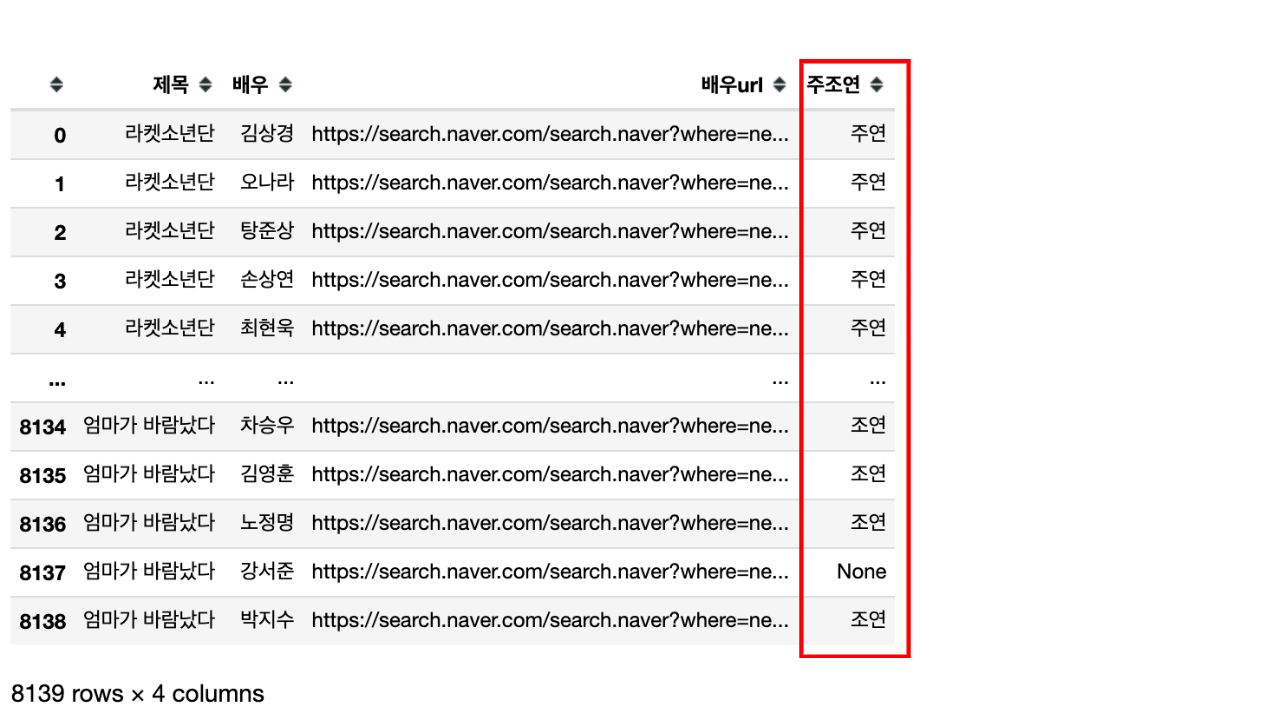

In [8]:
Image('img/main_df.png',width=730)

### 합체

나이 정보가 있는 age_df_check 와 <p>
주·조연 정보가 있는 m_df를 pandas 라이브러리에 있는 merge함수를 써서 병합했다. (~~합체~~)

```python
merged_df = pd.merge(age_df_check,m_df, how='outer',on=['제목','배우','배우url'])
merged_df.dropna(inplace=True)

main_df = merged_df.query("주조연=='주연'")
main_df.reset_index(inplace=True)
main_df.drop(columns='index')
```

In [9]:
merged_df = pd.merge(age_df_check,m_df, how='outer',on=['제목','배우','배우url'])
merged_df.dropna(inplace=True)

main_df = merged_df.query("주조연=='주연'")
main_df.reset_index(inplace=True)
main_df = main_df.drop(columns='index')

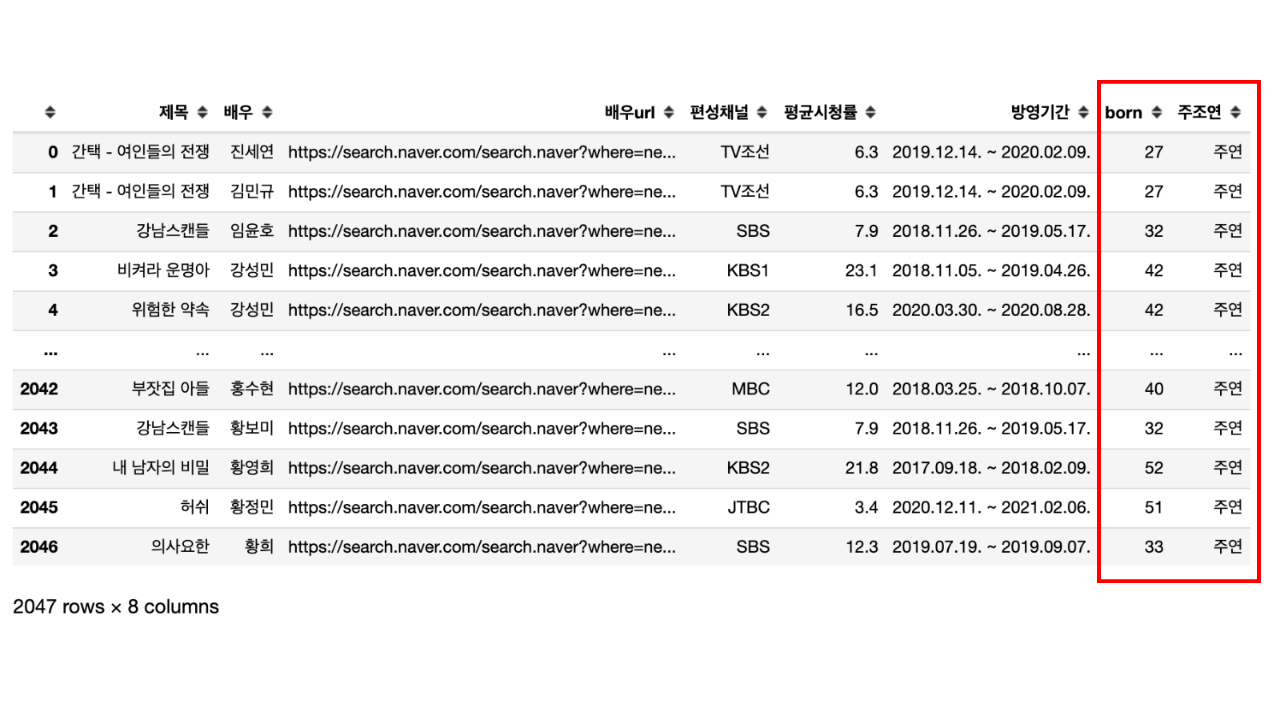

In [10]:
Image('img/merged_df.png',width=900)

### 드라마별 주연들의 연령대

코드보기를 해야 볼 수 있는 기나긴 코드를 거쳐서 다음과 같이 만들었다. <p><br>

과정을 설명해 보자면<p>
mongodb에 있는 드라마의 제목, 시청률 등의 정보를 가져오고<p>
위에서 병합한 데이터프레임에서 나이에 대한 column의 평균, 최대값, 표준편차 등을 구해서 새로운 데이터 프레임을 만들었다.

In [11]:
select_query = {'_id':0,'평균 시청률':1,'제목':1,'편성채널':1,'구독자수':1}
find_query = {'방영정보.방영기간':{'$gt':'2016'}}


require_cusor = db.require_update_phome_data.find({},select_query)
end_cusor = db.end_drama_phome_data.find(find_query,select_query)

drama_list = []
drama_rate = []
drama_chennel = []
drama_subscribe = []

for i in require_cusor:
    drama_list.append(i['제목'])
    drama_rate.append(i['평균 시청률'])
    drama_chennel.append(i['편성채널'])
    drama_subscribe.append(i['구독자수'])   
        
for i in end_cusor:
    drama_list.append(i['제목'])
    drama_rate.append(i['평균 시청률'])
    drama_chennel.append(i['편성채널'])
    drama_subscribe.append(i['구독자수'])
    
    
    
    
total_df = pd.DataFrame(columns=['제목','평균 시청률','평균 나이대','나이 중앙값','나이 표준편차','최고 나이','최저 나이','편성채널'])

age_mean = []
age_median = []
age_std = []
age_max = []
age_min = []

for i in drama_list:
    sql_query = f'제목 == "{i}"'
    age_mean.append(main_df.query(sql_query)['born'].mean())
    age_median.append(main_df.query(sql_query)['born'].median())
    age_std.append(main_df.query(sql_query)['born'].std())
    age_max.append(main_df.query(sql_query)['born'].max())
    age_min.append(main_df.query(sql_query)['born'].min())
    
    
total_df['제목'] = drama_list
total_df['평균 시청률'] = drama_rate
total_df['평균 나이대'] = age_mean
total_df['나이 중앙값'] = age_median
total_df['나이 표준편차'] = age_std
total_df['최고 나이'] = age_max
total_df['최저 나이'] = age_min
total_df['편성채널'] = drama_chennel
total_df['구독자수'] = drama_subscribe

In [12]:
total_df.dropna(inplace=True)
total_df

제목  평균 시청률     평균 나이대  나이 중앙값    나이 표준편차  최고 나이  최저 나이  \
0               라켓소년단     5.6  24.500000    18.5  14.696938   49.0   12.0   
1       슬기로운 의사생활 시즌2    13.2  39.000000    39.0   1.581139   41.0   37.0   
2             펜트하우스 3    15.7  42.166667    42.0   4.195958   49.0   36.0   
3              알고있지만,     1.5  27.000000    27.0   0.000000   27.0   27.0   
4             너는 나의 봄     2.4  36.250000    36.5   1.707825   38.0   34.0   
..                ...     ...        ...     ...        ...    ...    ...   
458            펜트하우스2    29.2  41.538462    43.0   3.478874   48.0   36.0   
459               타임즈     3.1  48.000000    47.5  16.062378   68.0   29.0   
460         결혼작사 이혼작곡     9.7  46.428571    49.0   8.482475   55.0   33.0   
461        루카 : 더 비기닝     6.3  39.666667    40.0   3.511885   43.0   36.0   
462  선배, 그 립스틱 바르지 마요     2.4  32.800000    32.0   6.058052   41.0   25.0   

     편성채널      구독자수  
0     SBS   12690.0  
1     tvN   65760.0  
2     SBS   49294.0  
3    JTBC   32568.0  
4     tvN   16590.0  
..    ...       ...  
458   SBS  101093.0  
459   OCN    6394.0  
460  TV조선   16239.0  
461   tvN   13171.0  
462  JTBC   20140.0  

[444 rows x 9 columns]

In [13]:
not_cable_df = total_df.query("편성채널 in ['KBS1','MBC','SBS','KBS2']")
cable_df = total_df.query("편성채널 not in ['KBS1','MBC','SBS','KBS2']")

## 시각화

해당 데이터 프레임을 지상파와 케이블로 나누어 <br>
x축은 주연들의 평균 나이<br>
y축은 드라마의 평균 시청률로 설정하고 그래프를 그렸다.

In [14]:
fig = px.scatter(not_cable_df,x='평균 나이대',y='평균 시청률',color='편성채널', hover_name='제목', title='지상파')
# axes range
fig.update_xaxes(range=[0, 80])
fig.update_yaxes(range=[0, 50])
fig.show()

In [15]:
fig = px.scatter(cable_df,x='평균 나이대',y='평균 시청률',color='편성채널', hover_name='제목', title='케이블')
# axes range
fig.update_xaxes(range=[0, 80])
fig.update_yaxes(range=[0, 50])
fig.show()

20~50대 사이에 연령대가 골고루 분포해 있고,<p>
시청률 또한 골고루 분포 되어있다.

별다른 특이한점은 없는데,<p>
한가지 보이는건 KBS1을 제외한 방송사에서 시청률 상위권 드라마의 연령대는 **'30 ~ 50대'** 라는 점이다.

In [16]:
fig = px.scatter(not_cable_df,x='나이 중앙값',y='평균 시청률',color='편성채널', hover_name='제목',title='지상파')
# axes range
fig.update_xaxes(range=[0, 80])
fig.update_yaxes(range=[0, 50])

fig.show()

In [17]:
fig = px.scatter(cable_df,x='나이 중앙값',y='평균 시청률',color='편성채널', hover_name='제목',title='케이블')
# axes range
fig.update_xaxes(range=[0, 80])
fig.update_yaxes(range=[0, 50])

fig.show()

---

## 결론

[이전 스토리](https://core.today/story/view/fe4b1eb3-0601-4963-9bec-279b14a53878)의 결론이었던<p>

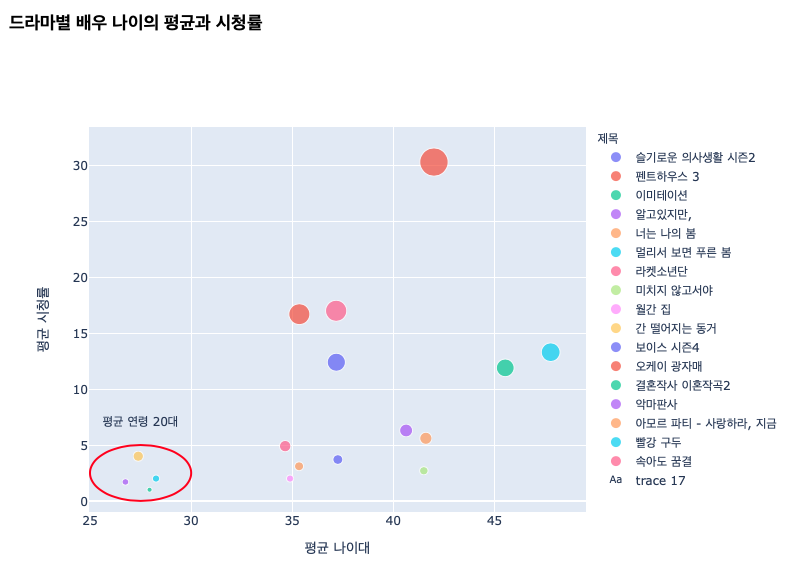

In [18]:
Image('img/이전그래프.png')

출연 배우들의 연령대가 20대가 주 라면, 시청률이 낮을 수 있다라는 결론은 21년도에만 적용이 되었다<p>
2016년 이후 드라마의 주연 평균 나이를 구했을 때<p>
어떤 뚜렷한 관계를 발견 할 수 없었다.

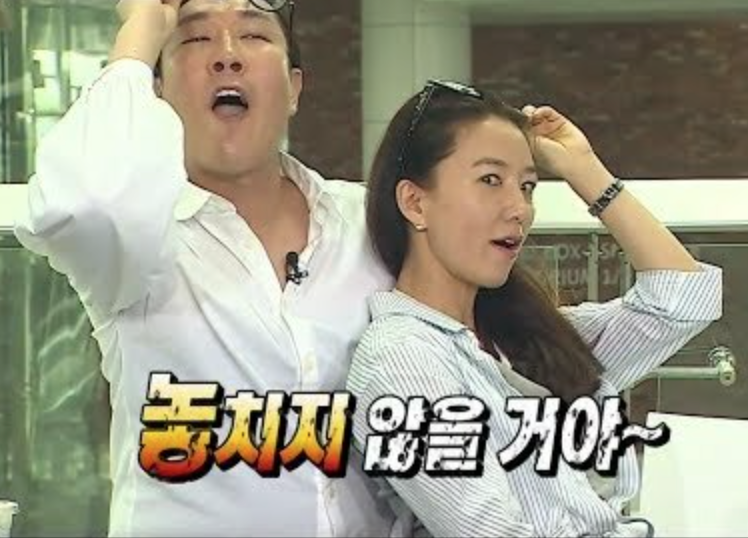

In [19]:
Image('img/놓치지.png',width=500)

하지만 시청률과 주연배우 나이 평균의 상관관계 놓치지 않을거다.<p>
다음 스토리에서는 연도별로 나누어서 상관관계를 살펴보자